# Ode to Palmyra 

This is the famous Palmyra record by Cobb (2003), updated in 2013 and available here:
https://www.ncdc.noaa.gov/cdo/f?p=519:1:::::P1_STUDY_ID:1875

In [42]:
%load_ext autoreload
%autoreload 2
import pyleoclim as pyleo
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
path = '/Users/julieneg/Documents/Science/Python/pyleoclim_affairs/palmyra/palmyra2013.txt'
df = pd.read_csv(path,skiprows=118, sep='\t')
df.head()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


,age,d18O
0,928.125,-4.651
1,928.209,-4.631
2,928.292,-4.629
3,928.375,-4.562
4,928.459,-4.580


Load it into a Pyleoclim Series, and flip so up means "warmer/fresher", indicative of El Niño conditions

Time axis values sorted in ascending order


(<Figure size 1000x400 with 1 Axes>,
 <AxesSubplot: xlabel='time [year CE]', ylabel='$\\delta^{18}$O x (-1) [‰]'>)

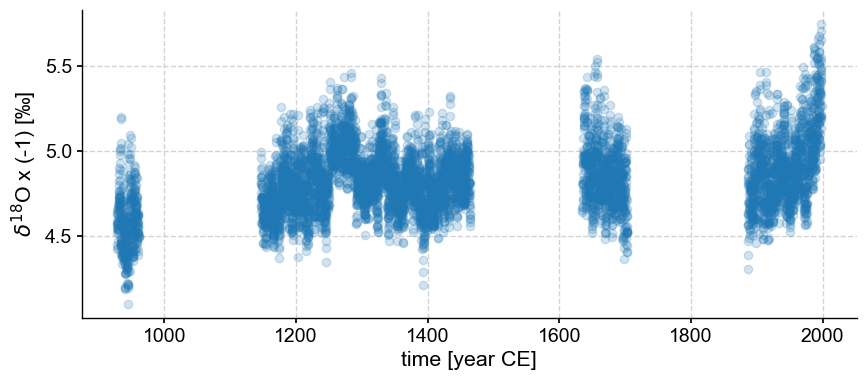

In [43]:
pal = pyleo.Series(time=df['age'], time_name='time', time_unit='year CE',
                       value=df['d18O'], value_name='$\delta^{18}$O', value_unit=u'‰').flip()    
pal.plot(marker='o',alpha=0.2, linewidth =0)

We see that there are 4 segments ; let's isolate and plot them one by one

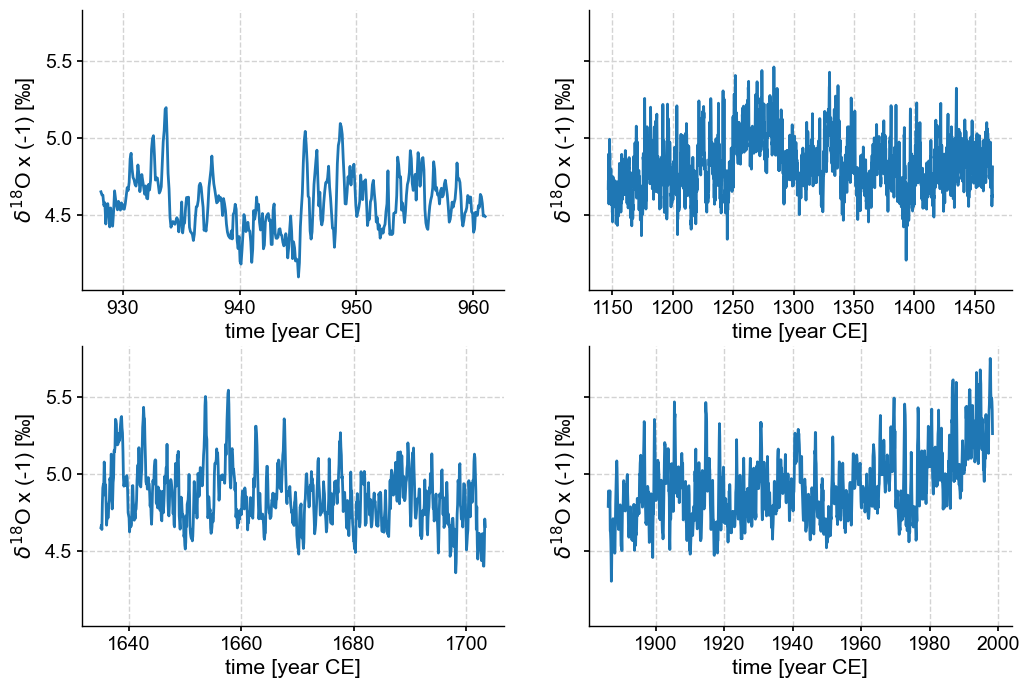

In [48]:
pals = pal.segment()
nseg = len(pals.series_list)
fig, ax = plt.subplots(2,2, sharey=True, figsize = (12,8))
ax = ax.flatten()
for i, ts, in enumerate(pals.series_list):
    ts.plot(ax=ax[i])

It is well-known that the 20th century warming signal has been accompanied by large-scale freshening, which induced a trend towards lighter (more negative) d18O. Let us filter the series in the [2,8y] band instead: 

ValueError: This  method assumes evenly-spaced timeseries, while the input is not. Use the ".interp()", ".bin()" or ".gkernel()" methods prior to ".filter()".

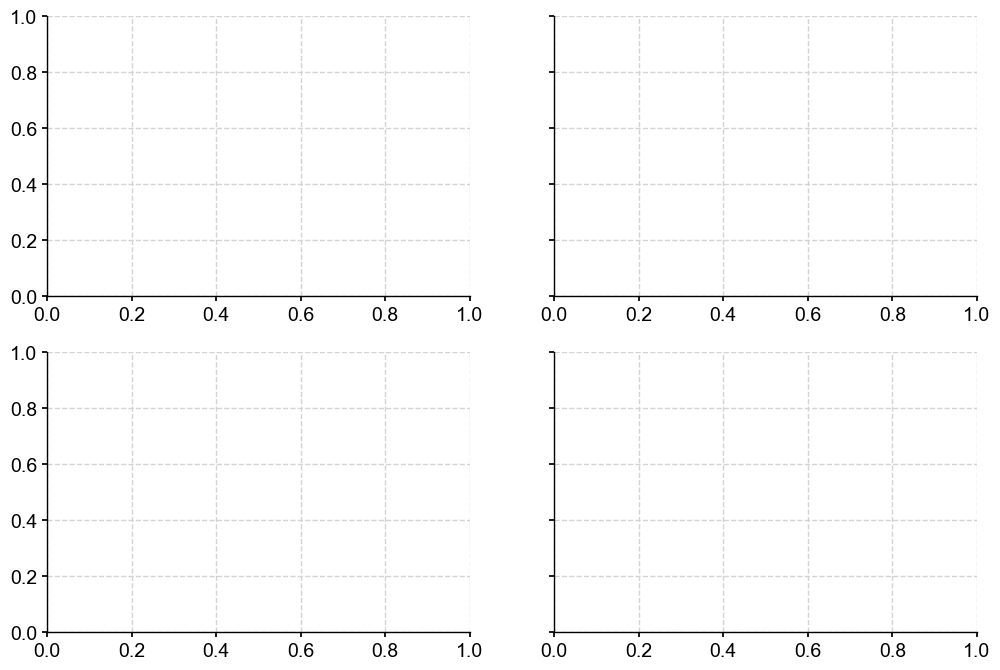

In [45]:
pals28 = pals.copy()  
fig, ax = plt.subplots(2,2, sharey=True, figsize = (12,8))
ax = ax.flatten()
for i, ts, in enumerate(pals.series_list):
    ts28 = ts.filter(cutoff_scale=[2,8], method = 'lanczos')
    ts28.plot(ax=ax[i])

The data are no exactly evenly spaced, which is a pain. It would be nice to resample them at monthly intervals, but the semantics do not lead themselves to that:

Instead, let's use good old fashioned linear interpolation:

Text(0.5, 0.98, 'Palmyra $\\delta^{18}$O record')

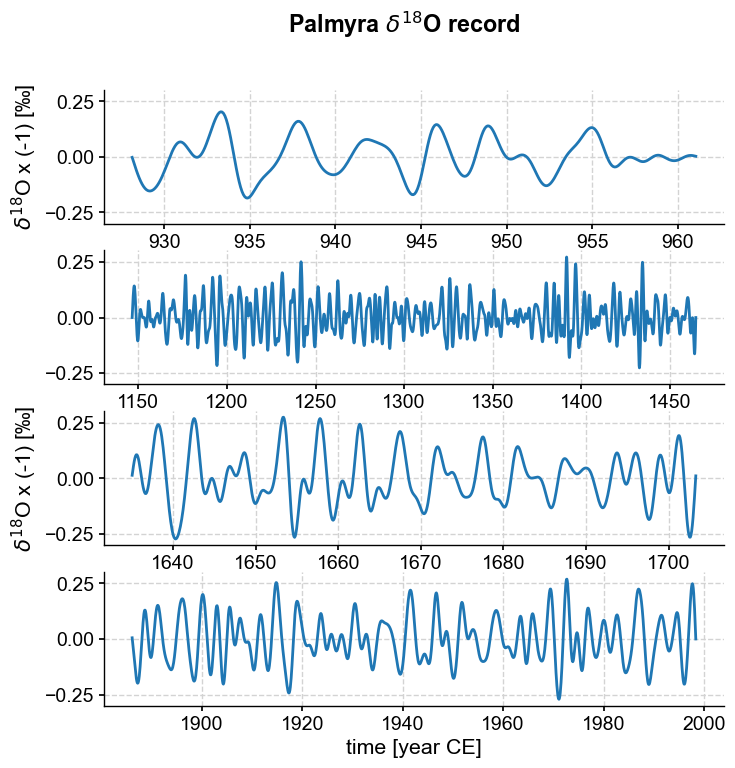

In [46]:
pals28 = pals.copy()  
fig, ax = plt.subplots(4,1, figsize = (8,8),sharey=True)
ax = ax.flatten()
for i, ts, in enumerate(pals.series_list):
    ts28 = ts.interp(step=1/12).filter(cutoff_scale=[2,8]).center()
    ts28.plot(ax=ax[i])
    pals28.series_list[i] = ts28
ax[0].set_xlabel(''); ax[1].set_xlabel('');
ax[1].set_ylabel(''); ax[3].set_ylabel(''); 
fig.suptitle('Palmyra $\delta^{18}$O record', fontweight = 'bold')

The second piece is nearly 3 centuries long, which makes it hard to compare to the other, much shorter segments:

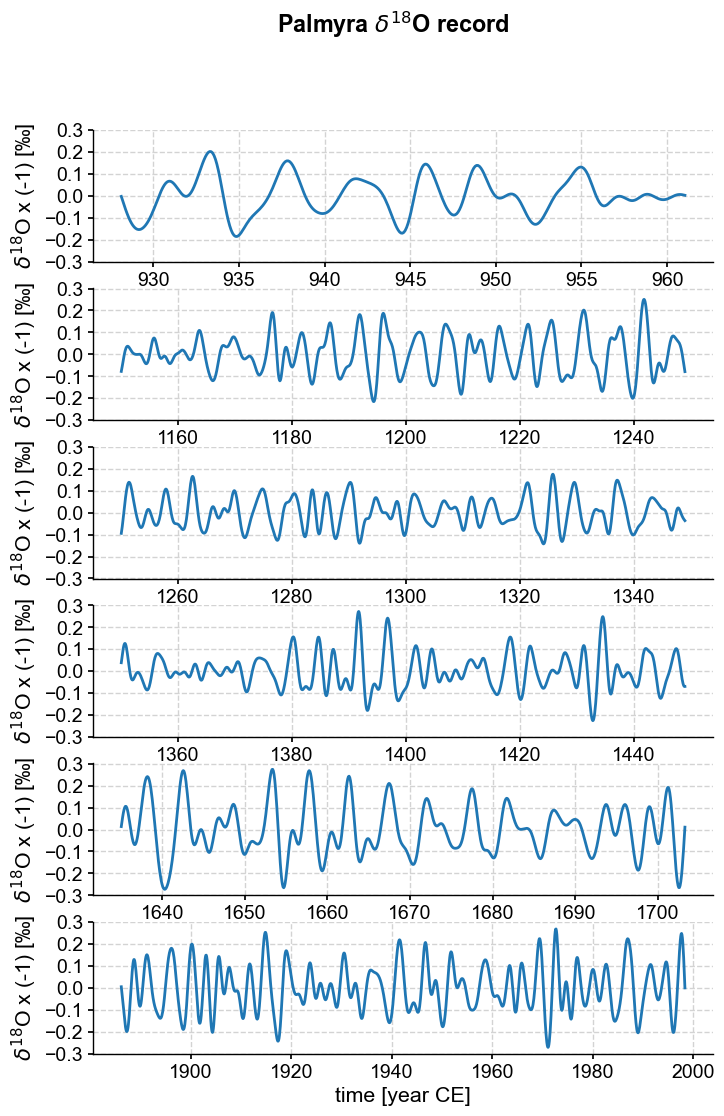

In [47]:
ts12 = pals28.series_list[1].sel(time=slice(1150,1249))
ts13 = pals28.series_list[1].sel(time=slice(1250,1349))
ts14 = pals28.series_list[1].sel(time=slice(1350,1449))

ms_plot = pyleo.MultipleSeries([pals28.series_list[0], ts12, ts13, ts14,
                                pals28.series_list[2], pals28.series_list[3]])

fig, ax = plt.subplots(6,1, figsize = (8,12),sharey=True)

ax = ax.flatten()
for i, ts, in enumerate(ms_plot.series_list):
    ts.plot(ax=ax[i])
    ax[i].set_yticks(np.arange(-.3, .35, step=.1))
fig.suptitle('Palmyra $\delta^{18}$O record', fontweight = 'bold')
fig.savefig('./palmyra_segments_2-8bandpass.pdf',dpi=300)

## Monthly resampling

it would have been nice to use the resampling capability with usual pandas semantics to sample at monthly intervals, but it doesn't work, because only the values provided in MATCH_A, MATCH_KA, MATCH_MA and MATCH_GA are accepted: 

In [49]:
ts.resample('1M').mean()

ValueError: Invalid unit provided, got: M

Would it be hard to also accept the usual pandas [periods frequency strings](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#timeseries-offset-aliases) as well, given that they do not conflict with the paleo ones?